Parameters

In [1]:
IMAGE_SHAPE = (16, 16)
BATCH_SIZE = 64
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 0.0003
VERBOSE = True
LABELS = True

# Imports

In [59]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import torch
import urllib
import random
import PIL
import glob
from IPython.display import Image

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Models

## Functions

In [58]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

## Unet

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [5]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [6]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

## Transforms

In [7]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [8]:
diffusion_model = DiffusionModel()

# Load data

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None, labels=False):
        self.subset = subset
        self.transform = transform
        self.labels = labels

    def __getitem__(self, index):
        if not self.labels:
          x = self.subset[index]
          x = x.convert('RGB')
          if self.transform:
            x = self.transform(x)
          return x
        else:
          x, y = self.subset[index]
          x = x.convert('RGB')
          if self.transform:
            x = self.transform(x)
          return x, y

    def __len__(self):
        return len(self.subset)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# if not extracted
# import os
# os.chdir('/content/drive/MyDrive/LAMIA_final-project/Rice-dataset')
# ! unzip imgs_with_label.zip -d imgs_with_label

In [11]:
import os
from PIL import Image

DRIVE_PATH = '/content/drive/MyDrive/LAMIA_final-project/Rice-dataset/imgs_with_label/imgs_with_label'

os.chdir(DRIVE_PATH)
current_directory = os.getcwd()
classes = os.listdir(current_directory)
dict_classes = {}
for i, clx in enumerate(classes):
  dict_classes[clx] = i
raw_data = []
for cls in classes:
  if cls == 'Rice_Citation_Request.txt':
    continue
  os.chdir(cls)
  current_directory = os.getcwd()
  imgs = os.listdir(current_directory)
  print(len(imgs))
  for item in imgs:
    raw_data.append((Image.open(item), dict_classes[cls]))
  os.chdir('../')
os.chdir('/content')

1000
1000
1000
1000
1000


In [12]:
random.shuffle(raw_data)

In [13]:
raw_data[:5]

[(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>, 3),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>, 2),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>, 3)]

In [14]:
SPLIT_TRAIN_TEST = 1000
train_data = raw_data[:SPLIT_TRAIN_TEST]
test_data = raw_data[SPLIT_TRAIN_TEST:]

train_dataset = CustomDataset(train_data, transform=transform, labels=LABELS)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

test_dataset = CustomDataset(train_data, transform=transform, labels=LABELS)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

In [15]:
import torchvision.transforms as T
from PIL import Image
trans = T.ToPILImage()
img = trans(train_dataset.__getitem__(3)[0])
img

# Train model

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
unet = UNet(labels=LABELS)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [22]:
epoch_loss = []
epoch_loss_val = []
to_gif = []
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in train_loader:
        label = torch.Tensor(label)
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch, label in test_loader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())

    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([0]*1).resize(1, 1).float().to(device)
        img = diffusion_model.backward(x=img, t=t, model=unet.eval().to(device), labels=labels)
    to_gif.append(img.squeeze())

    epoch_loss.append(np.mean(mean_epoch_loss))
    epoch_loss_val.append(np.mean(mean_epoch_loss_val))

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.8606915791829427 | Val Loss 0.6781526843706767
---
Epoch: 10 | Train Loss 0.157571479678154 | Val Loss 0.1472970277070999
---
Epoch: 20 | Train Loss 0.09127146750688553 | Val Loss 0.09314400454362233
---
Epoch: 30 | Train Loss 0.07200307125846545 | Val Loss 0.061171760658423106
---
Epoch: 40 | Train Loss 0.05668814107775688 | Val Loss 0.05791905398170153
---
Epoch: 50 | Train Loss 0.0472418246169885 | Val Loss 0.04888762459158898
---
Epoch: 60 | Train Loss 0.044136946896711986 | Val Loss 0.044768662005662915
---
Epoch: 70 | Train Loss 0.040739249686400095 | Val Loss 0.041110216577847795
---
Epoch: 80 | Train Loss 0.044535591701666516 | Val Loss 0.03797693674763044
---
Epoch: 90 | Train Loss 0.0353089340031147 | Val Loss 0.032133104155460994


# Plots

## Generating images

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


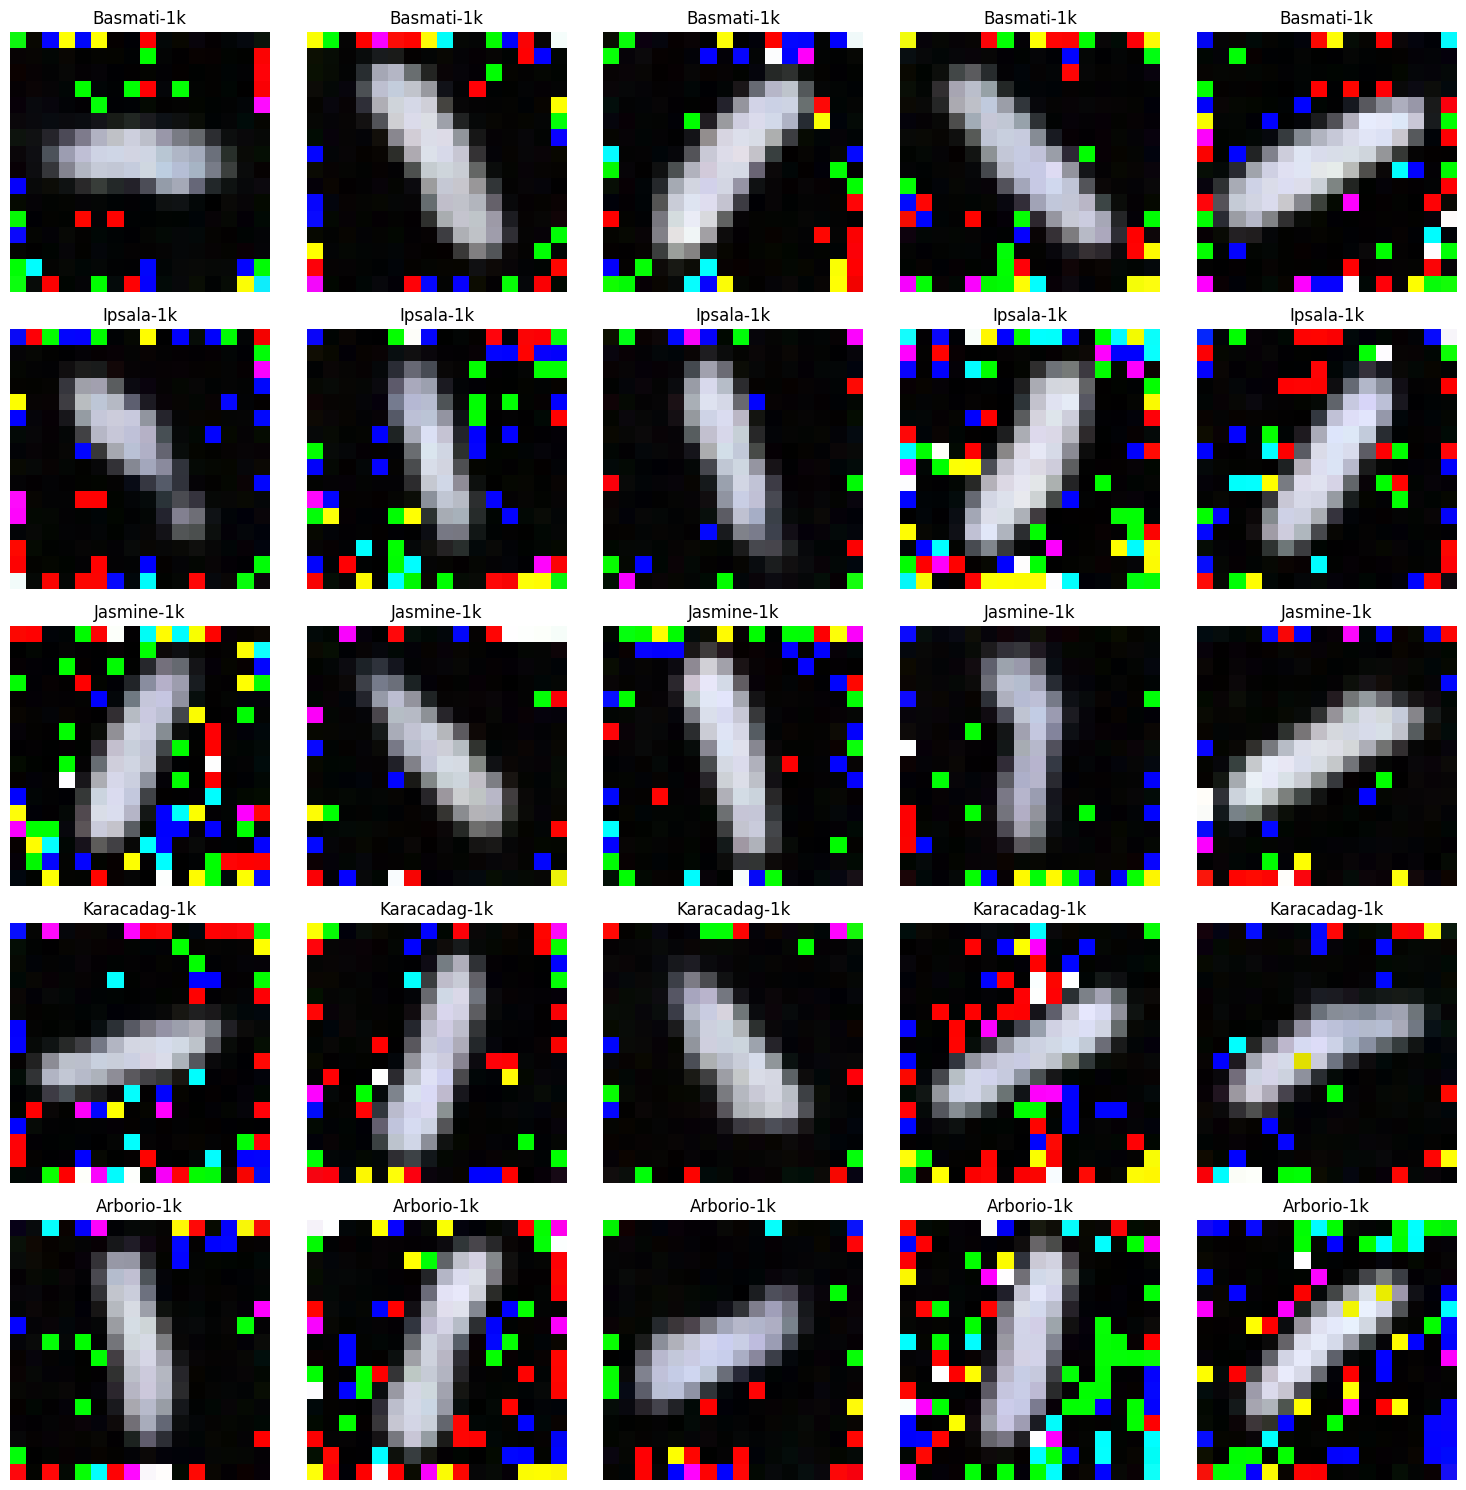

In [56]:
# Define the number of rows and columns in the grid
num_rows = len(classes)
num_cols = 5

# Create a new figure for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Iterate through each class
for cc, class_name in enumerate(classes):
    # Iterate through 5 examples for each class
    for example_index in range(5):
        img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
        for i in reversed(range(diffusion_model.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=device)
            labels = torch.tensor([0]*1).resize(1, 1).float().to(device)
            img = diffusion_model.backward(x=img, t=t, model=unet.eval().to(device), labels=labels)

        # Display the image in the corresponding subplot
        ax = axes[cc, example_index]
        ax.imshow(reverse_transform(img.squeeze()))
        ax.set_title(class_name)
        ax.axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()


## Losses

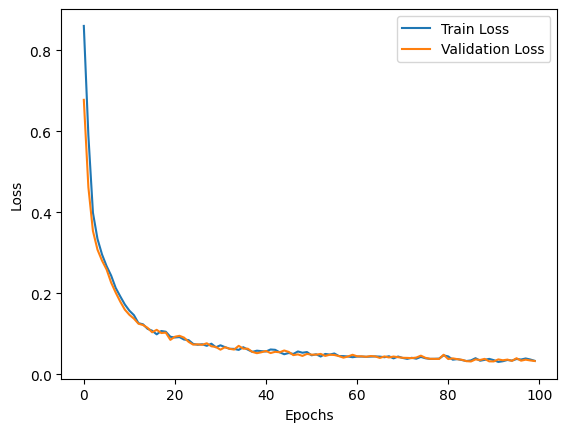

In [74]:
plt.plot(epoch_loss, label='Train Loss')
plt.plot(epoch_loss_val, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

## Turn images into GIF

In [62]:
to_gif_pil = [reverse_transform(x) for x in to_gif]

In [63]:
SAVE_PATH = '/content/drive/MyDrive/LAMIA_final-project/Rice-dataset/GIF/'
for i, img in enumerate(to_gif_pil):
  img = img.resize((512, 512))
  img.save(f'{SAVE_PATH}epoch-{i}.jpg')

In [64]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}*.jpg")]
    frame_one = frames[0]
    frame_one.save(f'{SAVE_PATH}rice-stable-diffusion.gif', format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

In [67]:
from PIL import Image
make_gif(SAVE_PATH)